In [1]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import warnings
import joblib

warnings.filterwarnings("ignore")
sp500_companies = pd.read_csv("/Users/keshavlodha/Downloads/ECS171_FINAL/data/sp500_companies.csv")
sp500_stocks = pd.read_csv("/Users/keshavlodha/Downloads/ECS171_FINAL/data/sp500_stocks.csv")
sp500_index = pd.read_csv("/Users/keshavlodha/Downloads/ECS171_FINAL/data/sp500_index.csv")

1) Exploratory Data Analysis

Text(0, 0.5, 'INDEX VALUE')

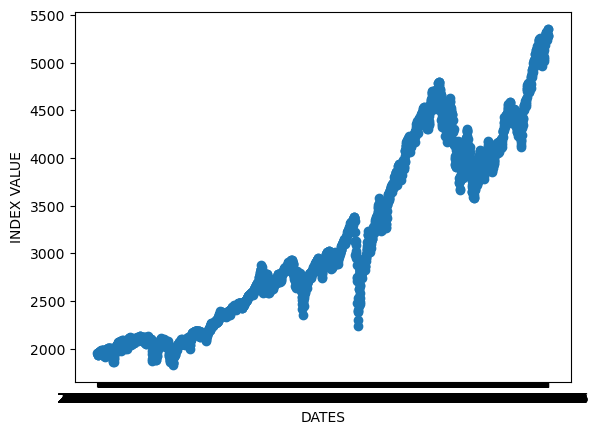

In [8]:
dates = sp500_index['Date']
index = sp500_index['S&P500']

plt.plot(dates, index, marker='o')
plt.xlabel("DATES")
plt.ylabel("INDEX VALUE")

We can see a consistent upward Trend for most of its time, except in 2020 due to the pandemic

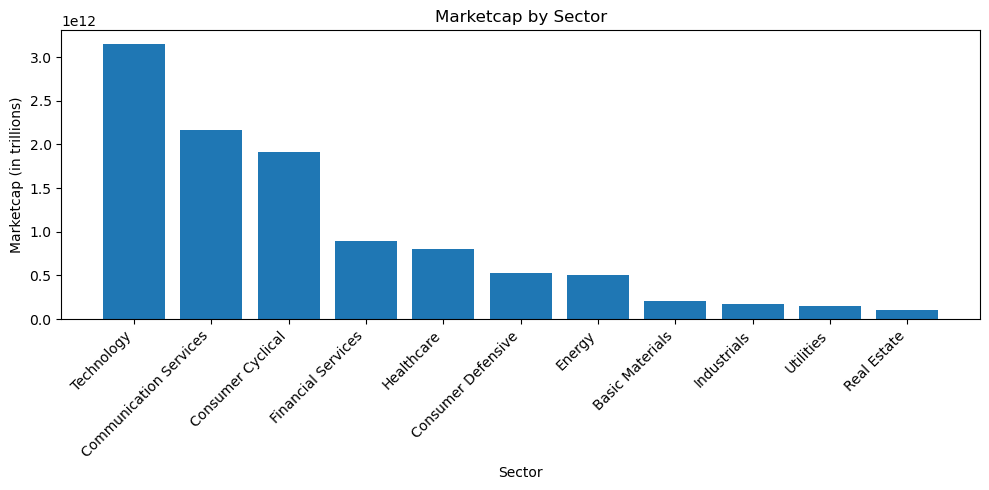

In [9]:
sp500_companies_sorted = sp500_companies.sort_values(by=["Marketcap"], ascending=False)
plt.figure(figsize=(10, 5))
plt.bar(sp500_companies_sorted['Sector'], sp500_companies_sorted['Marketcap'])

# Add title and labels
plt.title('Marketcap by Sector')
plt.xlabel('Sector')
plt.ylabel('Marketcap (in trillions)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()



The sectors with the highest market capitalization are Technology, Communication Services, and Financial Services. The sectors with the lowest market capitalization are Basic Materials, Utilities, and Real Estate.

In [ ]:
sp500_companies_sorted = sp500_companies.sort_values(by=["Marketcap"], ascending=False)
plt.figure(figsize=(10, 5))
plt.bar(sp500_companies_sorted['City'], sp500_companies_sorted['Marketcap'])

# Add title and labels
plt.title('Marketcap by City')
plt.xlabel('City')
plt.ylabel('Marketcap (in trillions)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=10))

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
sp500_companies[sp500_companies['State'].isnull()].head(3)
sp500_companies = sp500_companies.drop(['State'], axis=1)
sp500_companies.head(3)

We have identified State Variable has NaN values and removed it because we will be conduction Stock Analysis by Country only

In [ ]:
import seaborn as sns
sns.set(style='darkgrid')
plt.figure(figsize=(15,12))
sns.pairplot(sp500_companies, corner=True, hue='Exchange')
plt.tight_layout()


We can see a linear relationship between Marketcap and Weights (calculated from Marketcap).

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib

# Load the data
sp500_stocks = pd.read_csv('/Users/keshavlodha/Downloads/ECS171_FINAL/ecs 171 final project dead/sp500_stocks.csv')
sp500_companies = pd.read_csv('/Users/keshavlodha/Downloads/ECS171_FINAL/ecs 171 final project dead/sp500_companies.csv')

# Convert Date to datetime
sp500_stocks['Date'] = pd.to_datetime(sp500_stocks['Date'])

# Merge with company data
data = sp500_stocks.merge(sp500_companies, on='Symbol')

# Sort by date
data = data.sort_values(['Symbol', 'Date'])

# Feature Engineering
data['Prev_Close'] = data.groupby('Symbol')['Close'].shift(1)
data['Prev_Close'].fillna(method='bfill', inplace=True)

# Adding moving averages
data['MA_5'] = data.groupby('Symbol')['Close'].transform(lambda x: x.rolling(window=5).mean())
data['MA_10'] = data.groupby('Symbol')['Close'].transform(lambda x: x.rolling(window=10).mean())
data['MA_20'] = data.groupby('Symbol')['Close'].transform(lambda x: x.rolling(window=20).mean())
data.fillna(method='bfill', inplace=True)

# Select features and target
features = ['Prev_Close', 'MA_5', 'MA_10', 'MA_20']
target = 'Close'

# Splitting the data
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and save the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
joblib.dump(lr_model, '/Users/keshavlodha/Downloads/ECS171_FINAL/flask_ml_gui/LR_model.pkl')

# Train and save the Decision Tree model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
joblib.dump(dt_model, '/Users/keshavlodha/Downloads/ECS171_FINAL/flask_ml_gui/DT_model.pkl')


# Evaluate the models
y_pred_lr = lr_model.predict(X_test)
y_pred_dt = dt_model.predict(X_test)

print(f"Linear Regression Mean Squared Error: {mean_squared_error(y_test, y_pred_lr)}")
print(f"Decision Tree Mean Squared Error: {mean_squared_error(y_test, y_pred_dt)}")


def predict_stock_price_tomorrow(symbol):
    company_data = data[data['Symbol'] == symbol].sort_values('Date')
    if company_data.empty:
        return f"No data available for symbol: {symbol}"

    latest_data = company_data.iloc[-1]

    # Use the most recent data to predict tomorrow's price
    X_new = pd.DataFrame({
        'Prev_Close': [latest_data['Close']],
        'MA_5': [latest_data['MA_5']],
        'MA_10': [latest_data['MA_10']],
        'MA_20': [latest_data['MA_20']]
    })

    predicted_price_lr = lr_model.predict(X_new)[0]
    predicted_price_dt = dt_model.predict(X_new)[0]

    return {
        'Linear Regression': predicted_price_lr,
        'Decision Tree': predicted_price_dt,
    }

# Example usage
symbol = 'AAPL'
predictions = predict_stock_price_tomorrow(symbol)
print(f"Predicted stock prices for {symbol} for tomorrow:")
print(f"Linear Regression: {predictions['Linear Regression']}")
print(f"Decision Tree: {predictions['Decision Tree']}")